In [27]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
import matplotlib.pylab as plt
import os

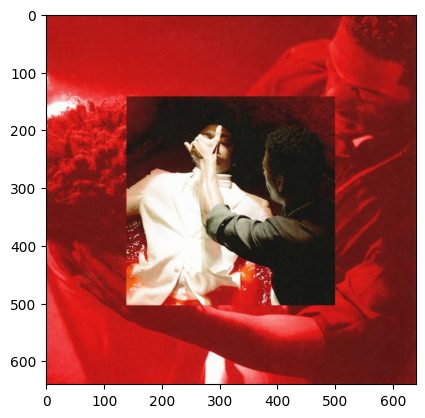

In [17]:
IMAGE_DIR = os.path.join(os.getcwd(), "large_dataset_imgs/large_cleaned_dataset_imgs")

def getImage(img_number):
    try:
        return io.imread(os.path.join(IMAGE_DIR, str(img_number) + '.jpg'))
    except FileNotFoundError as e:
        e.add_note("Could not get image [in getImage function], index " + str(img_number) + " doesn't exist")
        raise e


test = getImage(0)

plt.imshow(test)

In [32]:
hist = cv2.calcHist([test], [0,1,2], None, [8,8,8], [0, 256, 0, 256, 0, 256])
hist = cv2.normalize(hist, hist).flatten()

In [33]:
mean, std = cv2.meanStdDev(test)
features = np.concatenate([mean, std]).flatten()

In [ ]:
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)
edge_density = np.sum(edges) / edges.size

In [42]:
from utils import load_json_config
import pandas as pd
config = load_json_config("config.json")
DATA_CSV = pd.read_csv(os.path.join(os.getcwd(), config["organized_dataset_name"]))
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder

# Function to extract features from an image
def extract_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1. Color Histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()

    # 2. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
    lbp_hist = lbp_hist.astype("float") / lbp_hist.sum()

    # 3. Hu Moments
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    # Combine features
    features = np.hstack([hist, lbp_hist, hu_moments])
    return features

# Function to create labeled data
def createLabeledData():
    data = []
    labels = []

    for index, row in DATA_CSV.iterrows():
        print("Processing: ", index)
        album_id = row['album_id']
        genre = row['genre']

        # Build the image path
        # image_path = os.path.join(os.getcwd(), "images", f"{album_id}.jpg")

        # Check if image exists
        # if not os.path.exists(image_path):
        #     print(f"Image not found: {image_path}")
        #     continue

        # Load the image
        # image = cv2.imread(image_path)
        image = getImage(album_id)
        if image is None:
            print(f"Failed to load image: {album_id}")
            continue

        # Extract features
        features = extract_features(image)

        # Append to dataset
        data.append(features)
        labels.append(genre)

    # Convert to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

X, y = createLabeledData()

Processing:  0
Processing:  1
Processing:  2
Processing:  3
Processing:  4
Processing:  5
Processing:  6
Processing:  7
Processing:  8
Processing:  9
Processing:  10
Processing:  11
Processing:  12
Processing:  13
Processing:  14
Processing:  15
Processing:  16
Processing:  17
Processing:  18
Processing:  19
Processing:  20
Processing:  21
Processing:  22
Processing:  23
Processing:  24
Processing:  25
Processing:  26
Processing:  27
Processing:  28
Processing:  29
Processing:  30
Processing:  31
Processing:  32
Processing:  33
Processing:  34
Processing:  35
Processing:  36
Processing:  37
Processing:  38
Processing:  39
Processing:  40
Processing:  41
Processing:  42
Processing:  43
Processing:  44
Processing:  45
Processing:  46
Processing:  47
Processing:  48
Processing:  49
Processing:  50
Processing:  51
Processing:  52
Processing:  53
Processing:  54
Processing:  55
Processing:  56
Processing:  57
Processing:  58
Processing:  59
Processing:  60
Processing:  61
Processing:  62
Pr

In [44]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [45]:
# Split data into training and testing sets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Extracted features shape: {X.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")

Extracted features shape: (5286, 529)
Encoded labels shape: (5286,)
Random Forest Classifier Accuracy: 50.57%
